## open ltm dictionary, plot and analyze variables from each of the three datasets 

In [2]:
# data processing
import os
import pandas as pd, numpy as np, dask, json
import ogh
import geopandas as gpd
import ogh_xarray_landlab as oxl
import xarray as xr
import scipy.io

# data migration library
from utilities import hydroshare

# plotting and shape libraries
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
#hs=hydroshare.hydroshare()
#homedir = hs.getContentPath(os.environ["HS_RES_ID"])
homedir = '/home/jovyan/work/notebooks/GriddedMetDataDownload/projects/TemperatureSensorRegion'
os.chdir(homedir)
print('Data will be saved to:'+homedir)

Data will be saved to:/home/jovyan/work/notebooks/GriddedMetDataDownload/projects/TemperatureSensorRegion


In [4]:
# initialize ogh_meta
meta_file = dict(ogh.ogh_meta())
sorted(meta_file.keys())

['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014',
 'hourlywrf_pnnl']

### Load dictionary of data from all three datasets (livneh 2013, salathe 2014, PNNL 2018)

In [5]:
import pickle 
infile = open('TempSensorArea_2001to2015.pkl','rb') #rb - read binary
ltm = pickle.load(infile)
infile.close()

In [6]:
#check variables saved in dictionary
ltm.keys()

dict_keys(['PRECIP_dailymet_livneh2013', 'TMAX_dailymet_livneh2013', 'TMIN_dailymet_livneh2013', 'WINDSPD_dailymet_livneh2013', 'meanalldailysum_PRECIP_dailymet_livneh2013', 'monthsum_PRECIP_dailymet_livneh2013', 'meanbymonthsum_PRECIP_dailymet_livneh2013', 'meanmonthsum_PRECIP_dailymet_livneh2013', 'meanallmonthsum_PRECIP_dailymet_livneh2013', 'yearsum_PRECIP_dailymet_livneh2013', 'meanbyyearsum_PRECIP_dailymet_livneh2013', 'meanyearsum_PRECIP_dailymet_livneh2013', 'meanallyearsum_PRECIP_dailymet_livneh2013', 'PRECIP_dailywrf_salathe2014', 'TMAX_dailywrf_salathe2014', 'TMIN_dailywrf_salathe2014', 'WINDSPD_dailywrf_salathe2014', 'meanalldailysum_PRECIP_dailywrf_salathe2014', 'monthsum_PRECIP_dailywrf_salathe2014', 'meanbymonthsum_PRECIP_dailywrf_salathe2014', 'meanmonthsum_PRECIP_dailywrf_salathe2014', 'meanallmonthsum_PRECIP_dailywrf_salathe2014', 'yearsum_PRECIP_dailywrf_salathe2014', 'meanbyyearsum_PRECIP_dailywrf_salathe2014', 'meanyearsum_PRECIP_dailywrf_salathe2014', 'meanallyear

### Load temperature observations from field

In [86]:
filename = 'NCascades_AT.mat'

mat = scipy.io.loadmat(filename)

#range of dates to create new files for
start_date = '2007-09-01 00:30' 
end_date = '2008-09-30 23:00'

Hdates = [x.strftime('%Y-%m-%d %H:%M') for x in pd.date_range(start=start_date, end=end_date, freq='1.5H')]
Hddates = pd.to_datetime(Hdates)

start_dated = '2007-09-01' 
end_dated = '2008-09-30'
Ddates = [x.strftime('%Y-%m-%d') for x in pd.date_range(start=start_dated, end=end_dated, freq='D')]
Dddates = pd.to_datetime(Ddates)

#create hourly time series
Hdata = mat['AT']
dfh = pd.DataFrame(Hdata, columns = mat['sensor'].tolist(), index = Hddates )

#create daily time series Tmax
Ddata = mat['AT_maxT']
dfd_mx = pd.DataFrame(Ddata, columns = mat['sensor'].tolist(),index = Dddates )

#create daily time series Tmin
Ddata = mat['AT_minT']
dfd_min = pd.DataFrame(Ddata, columns = mat['sensor'].tolist(),index = Dddates )


#create daily time series Tmin
Ddata = mat['AT_meanT']
dfd_min = pd.DataFrame(Ddata, columns = mat['sensor'].tolist(),index = Dddates )


In [87]:
dfh.columns[12]

(13,)

### Define wateryear summary functions (ogh.aggregate_space_time_sum and average currently use annual year)

In [7]:
def WaterYear_Accum(df):
    
    """
    #df = S_PNNL_1981to1987['PREC_ACC_NC_hourlywrf_pnnl'] or any other dataframe in dictionary created by grid_clim_dict
    
    """
    #step 1, add water year (WY) column to data
    aa = df.index.to_series() #convert index to series so that lambda function can be applied 
    df['WY'] = aa.apply(lambda x: x.year if x.month < 10 else x.year+1)
    
    #step 2, remove datetime index to column, label column
    df_re = df.rename_axis('Date').reset_index()
    
    #step 3, move WY as index
    df_re.set_index('WY', inplace=True)
    
    #step 4, sum values in each column (grid point) by WY
    WYs_Sta = df_re.groupby(df_re.index).sum()
    
    #step 5, take mean of each grid cell as basin value
    WYs_basin = WYs_Sta.mean(axis=1)
    
    return(WYs_basin)


def WaterYear_Mean(df):
    
    """
    #df = S_PNNL_1981to1987['PREC_ACC_NC_hourlywrf_pnnl'] or any other dataframe in dictionary created by grid_clim_dict
    
    """
    #step 1, add water year (WY) column to data
    aa = df.index.to_series() #convert index to series so that lambda function can be applied 
    df['WY'] = aa.apply(lambda x: x.year if x.month < 10 else x.year+1)
    
    #step 2, remove datetime index to column, label column
    df_re = df.rename_axis('Date').reset_index()
    
    #step 3, move WY as index
    df_re.set_index('WY', inplace=True)
    
    #step 4, average values in each column (grid point) by WY
    WYm_Sta = df_re.groupby(df_re.index).mean()
    
    #step 5, take mean of each grid cell as basin value
    WYm_basin = WYm_Sta.mean(axis=1)
    
    return(WYm_basin)

### Analyze and plot variables

In [89]:
#create precip, temperature and solar radiation variables
PNNL_hp = ltm['PREC_ACC_NC_hourlywrf_pnnl']
#water year accumulated precip
WYp = WaterYear_Accum(PNNL_hp)
#water year mean temp
PNNL_hT = ltm['T2_hourlywrf_pnnl']
WYt = WaterYear_Mean(PNNL_hT)
#water year mean solar radiation W/m2
PNNL_hRs = ltm['SWDOWN_hourlywrf_pnnl']
WYs = WaterYear_Mean(PNNL_hRs)

#### Note: pnnl data is missing multi column index, add index back to pnnl variables

In [90]:
#Tmx_p_d = ltm['T2_hourlywrf_pnnl'].resample('D').max()
ltm['T2_hourlywrf_pnnl'].head()
#PNNL_hp.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,WY
2001-01-01 00:00:00,258.968842,257.480957,257.024109,257.332916,257.186951,256.994232,257.122345,256.548798,256.765167,259.218933,...,262.778839,262.704529,262.498352,260.840118,259.134674,262.999786,262.952209,262.628998,260.948090,2001
2001-01-01 01:00:00,257.610596,256.783783,256.267578,256.333069,255.972015,256.531555,256.684021,255.693100,256.127441,258.555573,...,261.228821,261.932343,261.582275,259.781372,258.151733,260.942932,261.281281,261.533508,259.824066,2001
2001-01-01 02:00:00,257.697937,256.820923,256.686951,256.480499,256.308044,256.845825,257.072906,256.352600,256.636810,258.639984,...,261.004333,261.815338,261.516541,259.681488,258.091431,260.703766,260.973816,261.435913,259.849487,2001
2001-01-01 03:00:00,258.277618,257.619690,257.541046,256.899384,257.212433,257.345795,257.977600,257.429840,257.699493,258.895660,...,261.582916,261.665497,261.267975,260.024323,258.441132,261.837097,261.093903,261.329834,260.080566,2001
2001-01-01 04:00:00,259.038757,258.291260,258.213654,257.435303,257.771271,257.940918,258.652954,258.070953,258.366028,259.480438,...,261.740967,260.350769,261.039764,260.401398,258.985596,261.730499,260.903259,261.289886,260.392975,2001


In [106]:
# check pnnl index
#reload column index
#RELOAD 1988 to 1994 because columns of orginal dataset also reset to index

infile = open('TempSensorArea_2001to2015_SepartePereods.pkl','rb') #rb - read binary
Ldict = pickle.load(infile)
infile.close()
os.chdir(homedir)

PNNL_COL = Ldict[0]['PREC_ACC_NC_hourlywrf_pnnl'].columns
#Ldict[0]['PREC_ACC_NC_hourlywrf_pnnl'].head(50).to_csv('PNNL_MultiIndex')

In [111]:
Ldict[1]['T2_hourlywrf_pnnl'].iloc[:,26].head(100)-273.15

2006-01-01 00:00:00   -10.445471
2006-01-01 01:00:00   -11.217657
2006-01-01 02:00:00   -11.334662
2006-01-01 03:00:00   -11.484503
2006-01-01 04:00:00   -12.799231
2006-01-01 05:00:00   -11.839209
2006-01-01 06:00:00   -10.987402
2006-01-01 07:00:00   -11.795355
2006-01-01 08:00:00   -10.990149
2006-01-01 09:00:00    -9.417212
2006-01-01 10:00:00    -8.992743
2006-01-01 11:00:00    -9.087622
2006-01-01 12:00:00   -10.490576
2006-01-01 13:00:00   -10.511816
2006-01-01 14:00:00   -10.396368
2006-01-01 15:00:00    -9.219672
2006-01-01 16:00:00    -8.416937
2006-01-01 17:00:00    -7.051337
2006-01-01 18:00:00    -5.271063
2006-01-01 19:00:00    -3.647528
2006-01-01 20:00:00    -2.453711
2006-01-01 21:00:00    -1.994788
2006-01-01 22:00:00    -2.150427
2006-01-01 23:00:00    -2.799414
2006-01-02 00:00:00    -4.322821
2006-01-02 01:00:00    -5.498755
2006-01-02 02:00:00    -5.461859
2006-01-02 03:00:00    -4.960944
2006-01-02 04:00:00    -4.848303
2006-01-02 05:00:00    -5.512823
          

In [92]:
# check liv and sal index
ltm['PRECIP_dailywrf_salathe2014'].head(50).to_csv('VIC_MultiIndex')
#Ldict[0]['PREC_ACC_NC_hourlywrf_pnnl'].head(50).to_csv('PNNL_MultiIndex')

### Plots

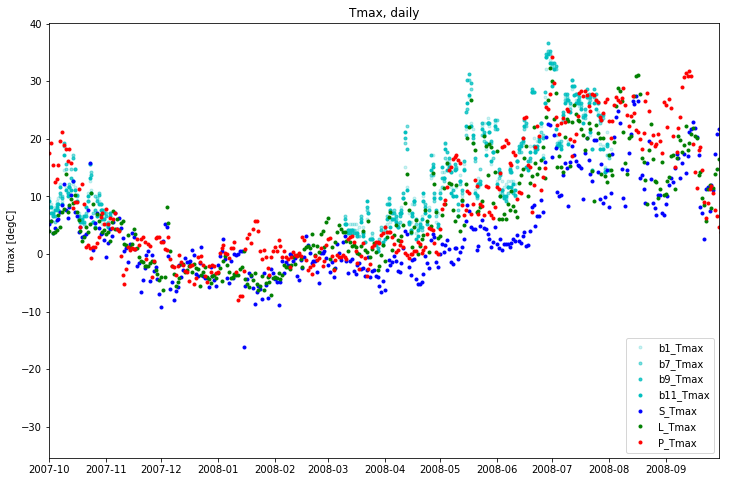

In [93]:

## Daily Tmax

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dfd_mx.iloc[:,0],'c.',linewidth=2.0,alpha=.2,label = 'b1_Tmax')
ax.plot(dfd_mx.iloc[:,6],'c.',linewidth=2.0,alpha=.5,label = 'b7_Tmax')
ax.plot(dfd_mx.iloc[:,8],'c.',linewidth=2.0,alpha=.8,label = 'b9_Tmax')
ax.plot(dfd_mx.iloc[:,10],'c.',linewidth=2.0,label = 'b11_Tmax')
ax.plot(ltm['TMAX_dailywrf_salathe2014'].iloc[:,12],'b.',linewidth=2.0,label = 'S_Tmax')
ax.plot(ltm['TMAX_dailymet_livneh2013'].iloc[:,12],'g.',linewidth=2.0,label = 'L_Tmax')
ax.plot(ltm['T2_hourlywrf_pnnl'].iloc[:,26].resample('D').max()-273.15,'r.',linewidth=2.0,label = 'P_Tmax')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('tmax [degC]')
plt.title('Tmax, daily')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('LE_Tmax_d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

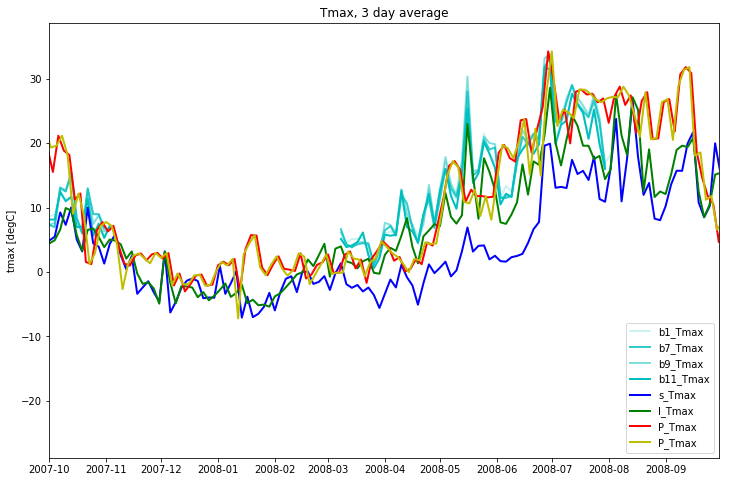

In [112]:
## 3 Day Tmax

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dfd_mx.iloc[:,0].resample('3D').mean(),'c-',linewidth=2.0,alpha=.2,label = 'b1_Tmax')
ax.plot(dfd_mx.iloc[:,6].resample('3D').mean(),'c-',linewidth=2.0,alpha=.8,label = 'b7_Tmax')
ax.plot(dfd_mx.iloc[:,8].resample('3D').mean(),'c-',linewidth=2.0,alpha=.5,label = 'b9_Tmax')
ax.plot(dfd_mx.iloc[:,10].resample('3D').mean(),'c-',linewidth=2.0,label = 'b11_Tmax')
ax.plot(ltm['TMAX_dailywrf_salathe2014'].iloc[:,12].resample('3D').mean(),'b-',linewidth=2.0,label = 's_Tmax')
ax.plot(ltm['TMAX_dailymet_livneh2013'].iloc[:,12].resample('3D').mean(),'g-',linewidth=2.0,label = 'l_Tmax')
ax.plot(ltm['T2_hourlywrf_pnnl'].iloc[:,26].resample('3D').max()-273.15,'r-',linewidth=2.0,label = 'P_Tmax')
ax.plot(Ldict[1]['T2_hourlywrf_pnnl'].iloc[:,26].resample('3D').max()-273.15,'y-',linewidth=2.0,label = 'P_Tmax')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('tmax [degC]')
plt.title('Tmax, 3 day average')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('LE_Tmax_3d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

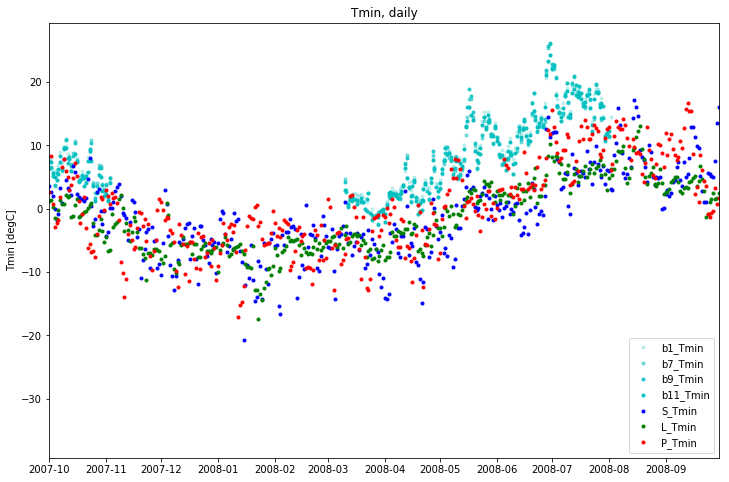

In [101]:

## Daily Tmin

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dfd_min.iloc[:,0],'c.',linewidth=2.0,alpha=.2,label = 'b1_Tmin')
ax.plot(dfd_min.iloc[:,6],'c.',linewidth=2.0,alpha=.5,label = 'b7_Tmin')
ax.plot(dfd_min.iloc[:,8],'c.',linewidth=2.0,alpha=.8,label = 'b9_Tmin')
ax.plot(dfd_min.iloc[:,10],'c.',linewidth=2.0,label = 'b11_Tmin')
ax.plot(ltm['TMIN_dailywrf_salathe2014'].iloc[:,12],'b.',linewidth=2.0,label = 'S_Tmin')
ax.plot(ltm['TMIN_dailymet_livneh2013'].iloc[:,12],'g.',linewidth=2.0,label = 'L_Tmin')
ax.plot(ltm['T2_hourlywrf_pnnl'].iloc[:,26].resample('D').min()-273.15,'r.',linewidth=2.0,label = 'P_Tmin')
#ax.plot(ltm['T2_hourlywrf_pnnl'].iloc[:,26]-273.15,'r.',linewidth=2.0,label = 'P_Tmin')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('Tmin [degC]')
plt.title('Tmin, daily')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('LE_Tmin_d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

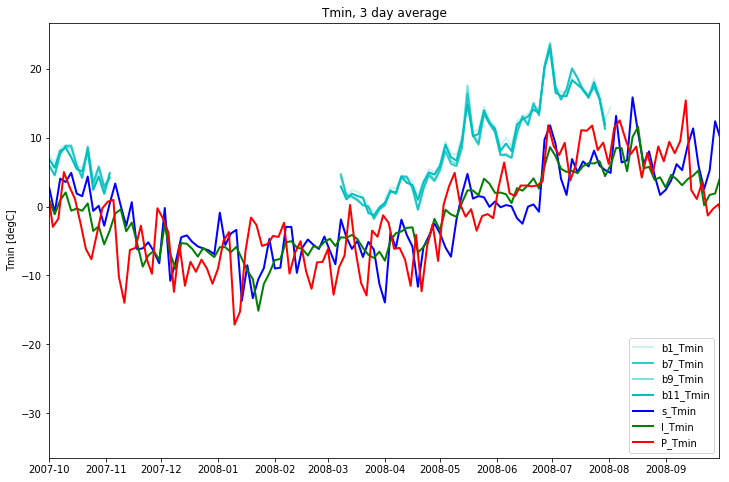

In [96]:
## 3 Day Tmin

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dfd_min.iloc[:,0].resample('3D').mean(),'c-',linewidth=2.0,alpha=.2,label = 'b1_Tmin')
ax.plot(dfd_min.iloc[:,6].resample('3D').mean(),'c-',linewidth=2.0,alpha=.8,label = 'b7_Tmin')
ax.plot(dfd_min.iloc[:,8].resample('3D').mean(),'c-',linewidth=2.0,alpha=.5,label = 'b9_Tmin')
ax.plot(dfd_min.iloc[:,10].resample('3D').mean(),'c-',linewidth=2.0,label = 'b11_Tmin')
ax.plot(ltm['TMIN_dailywrf_salathe2014'].iloc[:,12].resample('3D').mean(),'b-',linewidth=2.0,label = 's_Tmin')
ax.plot(ltm['TMIN_dailymet_livneh2013'].iloc[:,12].resample('3D').mean(),'g-',linewidth=2.0,label = 'l_Tmin')
ax.plot(ltm['T2_hourlywrf_pnnl'].iloc[:,26].resample('3D').min()-273.15,'r-',linewidth=2.0,label = 'P_Tmin')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('Tmin [degC]')
plt.title('Tmin, 3 day average')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('LE_Tmin_3d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

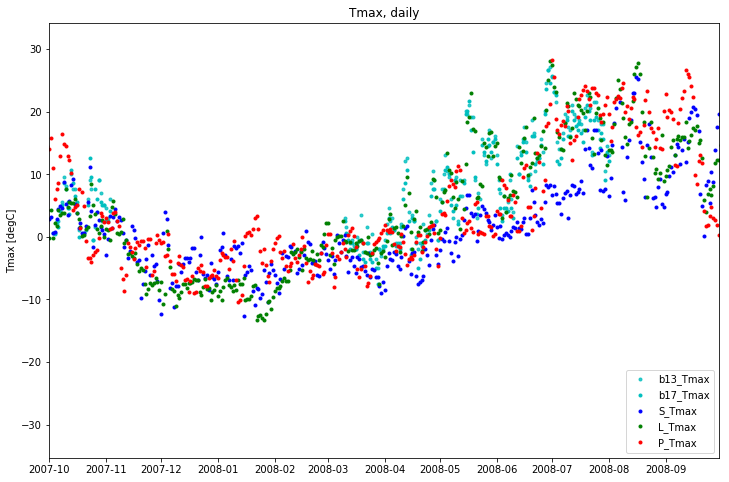

In [76]:
## High El, Daily Tmax

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dfd_mx.iloc[:,12],'c.',linewidth=2.0,alpha=.8,label = 'b13_Tmax')
ax.plot(dfd_mx.iloc[:,14],'c.',linewidth=2.0,label = 'b17_Tmax')
ax.plot(ltm['TMAX_dailywrf_salathe2014'].iloc[:,29],'b.',linewidth=2.0,label = 'S_Tmax')
ax.plot(ltm['TMAX_dailymet_livneh2013'].iloc[:,29],'g.',linewidth=2.0,label = 'L_Tmax')
ax.plot(ltm['T2_hourlywrf_pnnl'].iloc[:,5].resample('D').max()-273.15,'r.',linewidth=2.0,label = 'P_Tmax')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('Tmax [degC]')
plt.title('Tmax, daily')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('UE_Tmax_d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

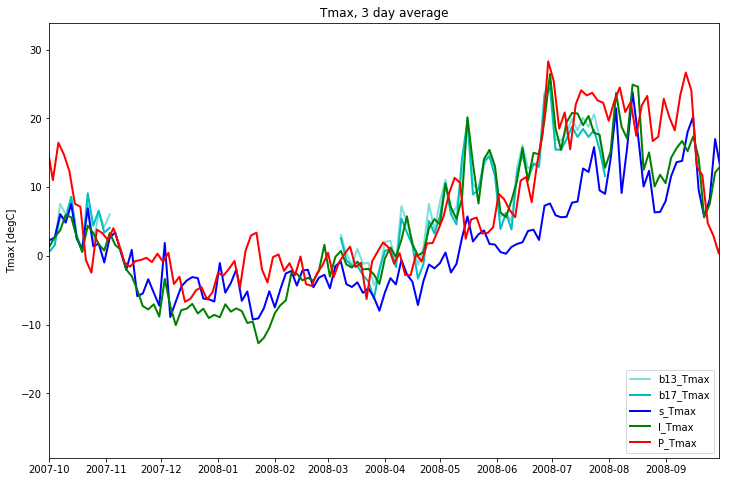

In [114]:
## 3 Day Tmax

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dfd_mx.iloc[:,12].resample('3D').mean(),'c-',linewidth=2.0,alpha=.5,label = 'b13_Tmax')
ax.plot(dfd_mx.iloc[:,14].resample('3D').mean(),'c-',linewidth=2.0,label = 'b17_Tmax')
ax.plot(ltm['TMAX_dailywrf_salathe2014'].iloc[:,29].resample('3D').mean(),'b-',linewidth=2.0,label = 's_Tmax')
ax.plot(ltm['TMAX_dailymet_livneh2013'].iloc[:,29].resample('3D').mean(),'g-',linewidth=2.0,label = 'l_Tmax')
ax.plot(ltm['T2_hourlywrf_pnnl'].iloc[:,5].resample('3D').max()-273.15,'r-',linewidth=2.0,label = 'P_Tmax')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('Tmax [degC]')
plt.title('Tmax, 3 day average')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('UE_Tmax_3d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

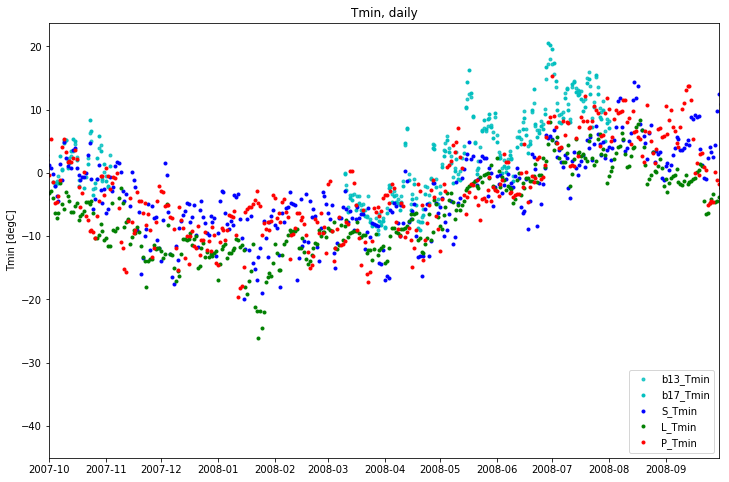

In [78]:

## Daily Tmin

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dfd_min.iloc[:,12],'c.',linewidth=2.0,alpha=.8,label = 'b13_Tmin')
ax.plot(dfd_min.iloc[:,14],'c.',linewidth=2.0,label = 'b17_Tmin')
ax.plot(ltm['TMIN_dailywrf_salathe2014'].iloc[:,29],'b.',linewidth=2.0,label = 'S_Tmin')
ax.plot(ltm['TMIN_dailymet_livneh2013'].iloc[:,29],'g.',linewidth=2.0,label = 'L_Tmin')
ax.plot(ltm['T2_hourlywrf_pnnl'].iloc[:,5].resample('D').min()-273.15,'r.',linewidth=2.0,label = 'P_Tmin')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('Tmin [degC]')
plt.title('Tmin, daily')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('UE_Tmin_d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

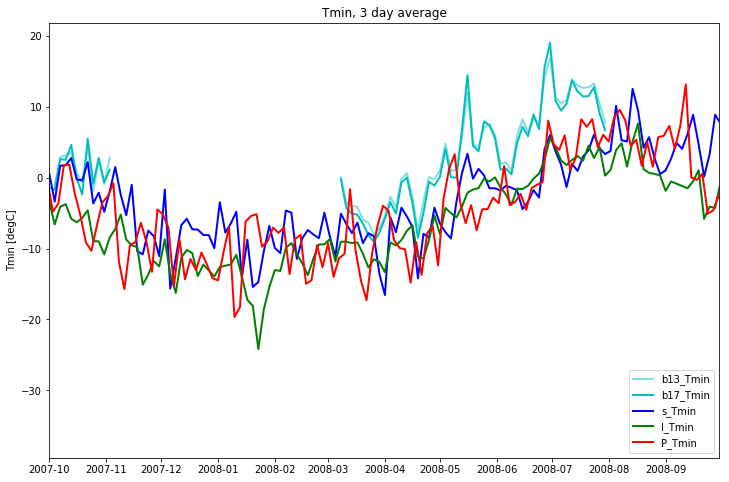

In [80]:
## 3 Day Tmin

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dfd_min.iloc[:,12].resample('3D').mean(),'c-',linewidth=2.0,alpha=.5,label = 'b13_Tmin')
ax.plot(dfd_min.iloc[:,14].resample('3D').mean(),'c-',linewidth=2.0,label = 'b17_Tmin')
ax.plot(ltm['TMIN_dailywrf_salathe2014'].iloc[:,29].resample('3D').mean(),'b-',linewidth=2.0,label = 's_Tmin')
ax.plot(ltm['TMIN_dailymet_livneh2013'].iloc[:,29].resample('3D').mean(),'g-',linewidth=2.0,label = 'l_Tmin')
ax.plot(ltm['T2_hourlywrf_pnnl'].iloc[:,5].resample('3D').min()-273.15,'r-',linewidth=2.0,label = 'P_Tmin')
# =============================================================================
# ax.plot(Tmx_S_d.index,Tmx_S_d,'g.',linewidth=2.0,label = 'Salathe')
# ax.plot(PNNL_hT_v_d_mx.index, PNNL_hT_v_d_mx,'r.',alpha = .2,linewidth=2.0,label = 'PNNL')
# 
# =============================================================================
plt.xlim(['2007-10-01','2008-09-30'])
# plt.ylim([0,1])
# plt.xticks(np.arange(0, 1.5, .25))
#plt.xlabel('date')
plt.ylabel('Tmin [degC]')
plt.title('Tmin, 3 day average')
#plt.grid()

legend = ax.legend(loc = 'lower right')
plt.savefig('UE_Tmin_3d.jpg', dpi = 300, bbox_inches='tight')

plt.show()

In [ ]:
#TO DO
# ADD Elevaation of grid point, add more grid points
# Add elevation to tidbit
# Add more grid points, are all PNNL temps different from obs?
# Double check way pnnl netcdf fiels are appended. could it be that appended out of order?